In [1]:
import re

import pandas as pd
import re, string
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter
from multiprocessing import Pool
from urllib.parse import urlparse

%matplotlib inline

In [2]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression

In [3]:
path = Path('Data/')

In [4]:
df = pd.read_feather(path/'May2015_subset.fthr')

/home/gokul/anaconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [5]:
subreddit_list = ['worldnews', 'movies', 'gaming', 'science', 'food']

In [6]:
df = df[df.subreddit.isin(subreddit_list)]

In [7]:
df.reset_index(inplace=True, drop=True)

In [8]:
df['subreddit'] = df.subreddit.astype('category')
df['subreddit_id'] = df.subreddit_id.astype('category')
df['distinguished'] = df.distinguished.astype('category')

In [9]:
df['is_flair'] = ~df.author_flair_text.apply(lambda x: x is None)
df['is_flair_css'] = ~df.author_flair_css_class.apply(lambda x: x is None)

Columns with no extra information

In [10]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        print(col)

score_hidden
removal_reason
downs
archived


In [11]:
df.drop(['archived', 'id', 'removal_reason',
         'score_hidden', 'downs', 'subreddit_id',
         'author_flair_css_class', 'author_flair_text',
         'author'], axis=1, inplace=True)

In [12]:
import gc
gc.collect()

49

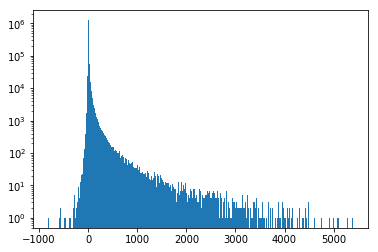

In [13]:
plt.hist(df.score, log=True, bins=300);

In [14]:
df.subreddit.value_counts()

worldnews    490354
movies       376601
gaming       361265
science       89413
food          55231
Name: subreddit, dtype: int64

In [15]:
df['time'] = pd.to_datetime(df.created_utc, unit='s')

In [16]:
df.drop(['created_utc'], axis=1, inplace=True)

In [17]:
df.tail().T

,1372859,1372860,1372861,1372862,1372863
ups,1,1,170,9,37
link_id,t3_37z0mw,t3_37z0mw,t3_37zl5z,t3_380j06,t3_37z0mw
name,t1_crrbebf,t1_crrbecs,t1_crrbedn,t1_crrbefm,t1_crrbeft
subreddit,worldnews,worldnews,worldnews,worldnews,worldnews
gilded,0,0,0,0,0
score,1,1,170,9,37
retrieved_on,1433505915,1433505915,1433505916,1433505916,1433505916
body,"The key there is ""unless they're sociopaths"". ...",Pretty sure they don't just behead people outr...,Because it's not typically done to babies. It'...,&gt; Nothing they are doing is illegal under i...,Apart from the risk of inhalation pneumonia.
distinguished,NaN,NaN,NaN,NaN,NaN
edited,0,0,0,0,0


In [18]:
dfl = pd.read_pickle('Data/scrape/df_final.pkl')

In [19]:
dfl.shape

(45400, 18)

Over lapping columns

In [20]:
[c for c in df.columns if c in dfl.columns]

['ups', 'score', 'distinguished', 'edited']

In [21]:
for col in dfl.columns:
    if len(dfl[col].unique()) == 1:
        print(col)

locked
downs
is_original_content
view_count


This will save some precious RAM when joining the data frame!!

In [22]:
dfl['url'] = dfl.url.astype('category')
dfl['selftext'] = dfl.selftext.astype('category')
dfl['title'] = dfl.title.astype('category')

In [23]:
dfl['link_created_time'] = pd.to_datetime(dfl.created_utc, unit='s')

In [24]:
dfl.drop(['locked', 'downs', 'is_original_content',
          'view_count', 'distinguished', 'edited',
          'num_crossposts', 'spoiler', 'created_utc'], axis=1, inplace=True)

In [25]:
dfl.rename(columns={'sub_id':'link_id', 
                    'ups': 'link_ups',
                    'score': 'link_score'}, inplace=True)

In [26]:
dfl.tail().T

,45395,45396,45397,45398,45399
link_id,t3_380j06,t3_380k50,t3_380ld3,t3_380lty,t3_380msc
url,https://www.yahoo.com/news/us-demands-immediat...,http://www.irishtimes.com/news/world/middle-ea...,http://www.timesofisrael.com/israels-army-skir...,http://time.com/3902702/us-college-student-isi...,http://www.healthy4u.net/2015/05/30/easy-diet-...
num_comments,10,1,6,5,1
over_18,False,False,False,False,False
link_score,9,9,0,8,1
selftext,,,,,
title,"US hits out at China over sea reclamation, vow...",Israel moves to toughen sentences for stone-th...,Israel's Army operating program to convert Jew...,Hero Student Tries to Stop ISIS Attack in Saud...,easy diet
upvote_ratio,0.62,0.84,0.38,0.68,1
link_ups,9,9,0,8,1
link_created_time,2015-05-31 23:19:50,2015-05-31 23:29:11,2015-05-31 23:38:41,2015-05-31 23:42:18,2015-05-31 23:50:20


In [27]:
df = df.merge(dfl, on='link_id', how='left')
# for some reason the join doesn't work
# df = df.join(other=dfl, on='link_id', how='outer')

In [28]:
df.shape

(1372864, 24)

In [29]:
f"{df.memory_usage(deep=True).sum() / 1023.0**3} GB"

'0.9037070584606572 GB'

In [30]:
def pd_to_dict(df, index='', column=''):
    return pd.Series(df[column].values, index=df[index]).to_dict()

In [31]:
df['time_since_link'] = df.time - df.link_created_time

In [32]:
df.time_since_link = df.time_since_link.apply(lambda x: x.total_seconds())

In [33]:
comment_to_parent_dict = pd_to_dict(df[['name', 'parent_id']],
                                    index='name', column='parent_id')

def get_depth(x):
    counter = 0
    temp = x
    while True:
        if temp[:3] == 't3_':
            return counter
        try:
            temp = comment_to_parent_dict[temp]
        except KeyError:
            return np.nan
        counter += 1
        
df['depth'] = df['name'].apply(get_depth)

Just keeping the domain

In [34]:
df['url'] = df.url.astype('str').apply(lambda x: urlparse(x)[1])
dfl['url'] = dfl.url.astype('category')

In [35]:
df['linked_sr'] = df.body.apply(lambda x: re.findall(r"/r/([^\s/]+)", x))
df['body'] = df.body.apply(lambda x: re.sub(r"(/r/[^\s/]+)", '', x))

In [36]:
regex = re.compile('[^a-zA-Z]')

In [37]:
df['linked_sr'] = df.linked_sr.apply(lambda x: [regex.sub('', i).lower() for i in x])

In [38]:
url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

def get_domains(x):
    x = x.replace(' = ', '=')
    x = x.replace(' : ', ':')
    x = x.replace(' / ', '?')
    urls = re.findall(url_regex, x)
    try:
        domain_names = [urlparse(url)[1] for url in urls]
    except:
        return []
    return domain_names

def remove_urls(x):
    x = x.replace(' = ', '=')
    x = x.replace(' : ', ':')
    x = x.replace(' / ', '?')
    return re.sub(url_regex, '', x)


df['linked_urls'] = df.body.apply(lambda x: get_domains(x))
df['body'] = df.body.apply(lambda x: remove_urls(x))

In [39]:
df['no_of_linked_sr'] = df['linked_sr'].apply(lambda x: len(x))
df['no_of_linked_urls'] = df['linked_urls'].apply(lambda x: len(x))

In [40]:
top_url_links = []

for sub in df.subreddit.unique():
    all_linked_urls = []
    for l in df[df.subreddit == sub].linked_urls.values:
        all_linked_urls += l

    top_url_links += Counter(all_linked_urls).most_common(5)

allowed_urls = list(set([i[0] for i in top_url_links]))

In [41]:
top_sr_links = []

for sub in df.subreddit.unique():
    all_linked_sr = []
    for l in df[df.subreddit == sub].linked_sr.values:
        all_linked_sr += l

    top_sr_links += Counter(all_linked_sr).most_common(5)

allowed_sr = list(set([i[0] for i in top_sr_links]))

In [42]:
def remove_sr(x):
    y = []
    for i in x:
        if i in allowed_sr:
            y += [i]
    return y

def remove_urls(x):
    y = []
    for i in x:
        if i in allowed_urls:
            y += [i]
    return y

df['a_linked_urls'] = df['linked_urls'].apply(lambda x: remove_urls(x))
df['a_linked_sr'] = df['linked_sr'].apply(lambda x: remove_sr(x))

In [43]:
comment_to_score = pd_to_dict(df[['name', 'score']],
                              index='name', column='score')

def get_score(x):
    try:
        return comment_to_score[x]
    except:
        return np.nan

df['parent_score'] = df.parent_id.apply(lambda x: get_score(x))
imp_val = df.parent_score.median()
df.parent_score.fillna(imp_val, inplace=True)

In [44]:
def get_comment_tree_root(x):
    if comment_to_parent_dict[x][:3] == 't3_':
        return x
    try:
        return get_comment_tree_root(comment_to_parent_dict[x])
    except KeyError:
        return np.nan

In [45]:
df['comment_tree_root_id'] = df.name.apply(get_comment_tree_root)

In [46]:
df['comment_tree_root_score'] = df.comment_tree_root_id.apply(lambda x: get_score(x))

In [47]:
comment_to_time = pd_to_dict(df[['name', 'time']],
                              index='name', column='time')

def get_time(x):
    try:
        return comment_to_time[x]
    except:
        return np.nan

In [48]:
df['time_since_comment_tree_root'] = df.time - df.comment_tree_root_id.apply(get_time)

In [49]:
df.time_since_comment_tree_root = df.time_since_comment_tree_root.apply(lambda x: x.total_seconds())

In [50]:
df['subjectivity'] = df['body'].str.count('I ')

In [51]:
df['is_edited'] = df.edited.apply(lambda x: x > 0)

In [52]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [53]:
def get_sentiment(x):
    return analyser.polarity_scores(x)

In [54]:
from multiprocessing import Pool

num_partitions = 100
num_cores = 6

def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [55]:
def wrapper_get_sentiment(df):
    df['sentiment'] = df['body'].apply(get_sentiment)
    return df

sentiment = parallelize_dataframe(df['body'].to_frame(), wrapper_get_sentiment)

df['senti_neg'] = sentiment['sentiment'].apply(lambda x: x['neg'])
df['senti_neu'] = sentiment['sentiment'].apply(lambda x: x['neu'])
df['senti_pos'] = sentiment['sentiment'].apply(lambda x: x['pos'])
df['senti_comp'] = sentiment['sentiment'].apply(lambda x: x['compound'])

del sentiment

In [56]:
gc.collect()

42

In [57]:
df['is_quoted'] = df.body.str.contains('&gt;')
df['no_quoted'] = df.body.str.count('&gt;')
df['time_since_parent'] = df.parent_id.apply(get_time)
df.loc[df.time_since_parent.isna(), 'time_since_parent'] = df.time
df.time_since_parent = df.time - df.time_since_parent
df.time_since_parent = df.time_since_parent.apply(lambda x: x.total_seconds())

In [58]:
df['is_root'] = df.parent_id.str.startswith('t3_')

In [59]:
df['is_selftext'] = df.selftext.str.len() > 1

In [60]:
df.shape

(1372864, 47)

In [62]:
def get_word_count(df):
    df['word_count'] = df['body'].apply(lambda x: len(x.split()))
    return df

word_counts = parallelize_dataframe(df['body'].to_frame(), get_word_count)
df['word_counts'] = word_counts.word_count

del word_counts

In [127]:
import gc
gc.collect()

609

Using Pandas `.query` method for high performance subsetting.
check [this out](https://jakevdp.github.io/PythonDataScienceHandbook/03.12-performance-eval-and-query.html)

In [124]:
def get_past_stats(x):
    lid = x[0]
    t = x[1]
    temp = df.query(f"link_id == '{lid}' and time < '{t}'")
    no_of_cmnts = temp.shape[0]
    score = temp['score'].sum()
    p = temp.query('score >= 0')['score'].sum()
    n = abs(temp.query('score < 0')['score'].sum())
    if not (p == 0 and n == 0):
        up_ratio = p / (p + n)
    else:
        up_ratio = 1
    return no_of_cmnts, score, up_ratio

In [131]:
def wrapper_past_stats(df):
    df['pat_stats'] = df.apply(get_past_stats, axis=1)
    return df

past_stats = parallelize_dataframe(dft, wrapper_past_stats)

In [ ]:
gc.collect()

In [6]:
import string
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

In [7]:
table = str.maketrans({key: ' ' for key in string.digits + string.punctuation + '\t\n\r'})

def load_glove(filename):
    glove = {}
    with open(filename, 'r') as read_file:
        for line in read_file:
            key = line.split(' ')[0]
            vector = np.array(line.split(' ')[1:], dtype=np.float)
            glove[key] = vector

    return glove

def words(text):
    text = text.lower()
    text = text.translate(table).strip()
    terms = text.split(' ')
    terms = [t for t in terms if len(t) > 2]
    terms = [t for t in terms if t not in ENGLISH_STOP_WORDS]

    return terms

def get_doc2vec(text, gloves):
    count_words = 0
    final_vector = 0
    terms = words(text)

    for t in terms:
        if t in gloves.keys():
            count_words += 1
            final_vector += gloves[t]
    if count_words != 0:
        return final_vector / count_words
    else:
        return None

gloves = load_glove('Data/glove.twitter.27B.200d.txt')

In [8]:
from scipy.spatial.distance import cosine

In [13]:
comment_to_body = pd_to_dict(df[['name', 'body']],
                                index='name', column='body')
comment_to_parent = pd_to_dict(df[['name', 'parent_id']],
                                index='name', column='parent_id')

def get_cosine_angle(cmnt_id):
    child = comment_to_body[cmnt_id]
    try:
        parent = comment_to_body[comment_to_parent[cmnt_id]]
    except KeyError:
        return None
    child = get_doc2vec(child, gloves)
    parent = get_doc2vec(parent, gloves)
    if child is None:
        return None
    if parent is None:
        return None
    return cosine(child, parent)

def wrapper_get_cosine(df):
    df['cosine_angle'] = df['name'].apply(get_cosine_angle)
    return df

cosine_angle = parallelize_dataframe(df['name'].to_frame(), wrapper_get_cosine)

df['parent_cos_angle'] = cosine_angle.cosine_angle

del cosine_angle

In [14]:
comment_to_body = pd_to_dict(df[['name', 'body']],
                                index='name', column='body')
comment_to_title = pd_to_dict(df[['name', 'title']],
                                index='name', column='title')

In [15]:
def get_cosine_angle(cmnt_id):
    child = comment_to_body[cmnt_id]
    try:
        parent = comment_to_title[cmnt_id]
        child = get_doc2vec(child, gloves)
        parent = get_doc2vec(parent, gloves)
    except:
        return None
    if child is None:
        return None
    if parent is None:
        return None
    return cosine(child, parent)

def wrapper_get_cosine(df):
    df['cosine_angle2'] = df['name'].apply(get_cosine_angle)
    return df

In [16]:
cosine_angle = parallelize_dataframe(df['name'].to_frame(), wrapper_get_cosine)

In [20]:
df['title_cos_angle'] = cosine_angle.cosine_angle2

del cosine_angle
del comment_to_body
del comment_to_parent
del comment_to_parent_dict
del comment_to_score
del comment_to_time
del comment_to_title
del glovesd

In [21]:
df.shape

(1372864, 49)

In [75]:
# df.to_pickle('Data/new_data.pkl')
df = pd.read_pickle('Data/new_data.pkl')

Cleaning

In [44]:
df.columns

Index(['ups', 'link_id', 'name', 'subreddit', 'gilded', 'score',
       'retrieved_on', 'body', 'distinguished', 'edited', 'controversiality',
       'parent_id', 'is_flair', 'is_flair_css', 'time', 'url', 'num_comments',
       'over_18', 'link_score', 'selftext', 'title', 'upvote_ratio',
       'link_ups', 'link_created_time', 'time_since_link', 'depth',
       'linked_sr', 'linked_urls', 'no_of_linked_sr', 'no_of_linked_urls',
       'a_linked_urls', 'a_linked_sr', 'parent_score', 'comment_tree_root_id',
       'comment_tree_root_score', 'time_since_comment_tree_root',
       'subjectivity', 'is_edited', 'senti_neg', 'senti_neu', 'senti_pos',
       'senti_comp', 'is_quoted', 'no_quoted', 'time_since_parent',
       'word_counts', 'cos_angle', 'title_cos_angle', 'parent_cos_angle',
       'is_root', 'is_selftext'],
      dtype='object')

In [76]:
df.distinguished.replace(to_replace=np.NaN, value='user', inplace=True)
df['distinguished'] = df.distinguished.astype('category')

In [77]:
df = df[~df.depth.isna()]

In [78]:
df.drop(['cos_angle'], inplace=True, axis=1)

In [80]:
df.loc[df.is_root, 'parent_cos_angle'] = 1

In [81]:
df.word_counts.quantile(0.995)

285.0

In [82]:
df = df[df['word_counts'] < 280]

In [83]:
df = df[df.body != '[deleted]']
df = df[df.body != '[removed]']
df = df[df.body != '']

In [84]:
df.reset_index(inplace=True, drop=True)

In [90]:
df = df[~df.title_cos_angle.isna()]
df = df[~df.parent_cos_angle.isna()]

In [91]:
df.shape

(1176815, 50)

In [92]:
import seaborn as sns

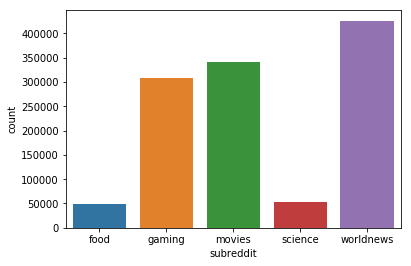

In [93]:
sns.countplot(data=df, x='subreddit')

In [94]:
df.columns

Index(['ups', 'link_id', 'name', 'subreddit', 'gilded', 'score',
       'retrieved_on', 'body', 'distinguished', 'edited', 'controversiality',
       'parent_id', 'is_flair', 'is_flair_css', 'time', 'url', 'num_comments',
       'over_18', 'link_score', 'selftext', 'title', 'upvote_ratio',
       'link_ups', 'link_created_time', 'time_since_link', 'depth',
       'linked_sr', 'linked_urls', 'no_of_linked_sr', 'no_of_linked_urls',
       'a_linked_urls', 'a_linked_sr', 'parent_score', 'comment_tree_root_id',
       'comment_tree_root_score', 'time_since_comment_tree_root',
       'subjectivity', 'is_edited', 'senti_neg', 'senti_neu', 'senti_pos',
       'senti_comp', 'is_quoted', 'no_quoted', 'time_since_parent',
       'word_counts', 'title_cos_angle', 'parent_cos_angle', 'is_root',
       'is_selftext'],
      dtype='object')

In [103]:
cat_cols = ['subreddit', 'distinguished', 'is_flair', 'is_flair_css']
bool_cols = ['over_18', 'is_edited', 'is_quoted', 'is_root', 'is_selftext']
# multi_label = url
numeric_cols = ['gilded', 'controversiality', 'num_comments', 'link_score',
                'upvote_ratio', 'link_ups', 'time_since_link', 'depth',
                'no_of_linked_sr', 'no_of_linked_urls', 'parent_score',
                'comment_tree_root_score', 'time_since_comment_tree_root',
                'subjectivity', 'senti_neg', 'senti_pos', 'senti_neu',
                'senti_comp', 'no_quoted', 'time_since_parent', 'word_counts',
                'title_cos_angle', 'parent_cos_angle']

In [98]:
from scipy.sparse import hstack

In [99]:
lb = LabelBinarizer()

In [106]:
cat = [lb.fit_transform(df[col]) for col in cat_cols]
bol = [df[col].astype('int') for col in bool_cols]
t = df.loc[:, numeric_cols].values
final = [t] + bol + cat

In [118]:
y = df.score.values
x = np.column_stack(tuple(final))

In [120]:
df.shape

(1176815, 50)

In [119]:
x.shape

(1176815, 38)

In [121]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=42)

In [122]:
from sklearn.ensemble import RandomForestRegressor

In [123]:
m = RandomForestRegressor(n_jobs=-1, n_estimators=40, min_samples_leaf=10)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [124]:
y_predicted = m.predict(X_test)
r2 = r2_score(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)
print(f"R-Sq: {r2:.4}")
print(f"RMSE: {np.sqrt(mse)}")

R-Sq: 0.7532
RMSE: 36.22493185419671


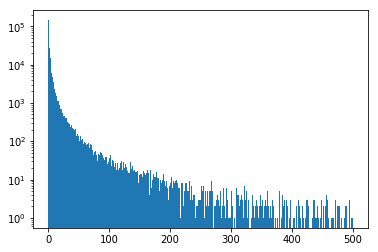

In [126]:
plt.hist(abs(y_test - y_predicted), bins=400, range=[0, 500], log=True);

In [127]:
from sklearn.ensemble import GradientBoostingRegressor

In [128]:
m = GradientBoostingRegressor(n_estimators=100, min_samples_leaf=10)
m.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=10,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [129]:
y_predicted = m.predict(X_test)
r2 = r2_score(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)
print(f"R-Sq: {r2:.4}")
print(f"RMSE: {np.sqrt(mse)}")

R-Sq: 0.6794
RMSE: 41.28348575152193


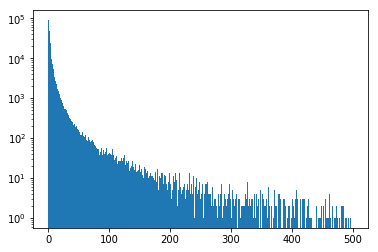

In [130]:
plt.hist(abs(y_test - y_predicted), bins=400, range=[0, 500], log=True);